In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.arima.model import ARIMA
from collections import defaultdict
import warnings
df = pd.read_csv("data/btc.csv", parse_dates=['time'])
rfr = pd.read_csv("data/rfr.csv", parse_dates=["observation_date"], dayfirst=True)
rfr.set_index("observation_date", inplace=True)
rfr.index = pd.to_datetime(rfr.index)
rfr = rfr[rfr.index <= pd.to_datetime("2025-04-16")]
rfr["rfr"] = np.log(rfr["rfr"]/100+1)
rfr['rfr'] = rfr['rfr'].ffill().bfill()  # fill both forward and back
crypto = pd.read_csv("crypto.csv")
crypto['snapped_at'] = pd.to_datetime(crypto["snapped_at"], unit='ms').dt.round("D")
crypto.set_index("snapped_at", inplace=True)
crypto = crypto[crypto.index <= pd.to_datetime("2025-04-16")]
df.set_index('time', inplace=True)
df = pd.merge_asof(df.sort_index(), rfr.sort_index(), left_index=True, right_index=True, direction='backward')
crypto = crypto.iloc[1:]

regimes = pd.read_csv("regimes.csv", parse_dates=["date"], dayfirst=True)
regimes.set_index('date', inplace=True)

/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_80931/1545193923.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("btc.csv", parse_dates=['time'])


In [2]:
n = 30
df["ln_close"] = np.log(df["close"])
df["ln_diff"] = df["ln_close"].diff()
df['smoothed'] = df['ln_diff'].rolling(n).mean()
df = df.iloc[1:]

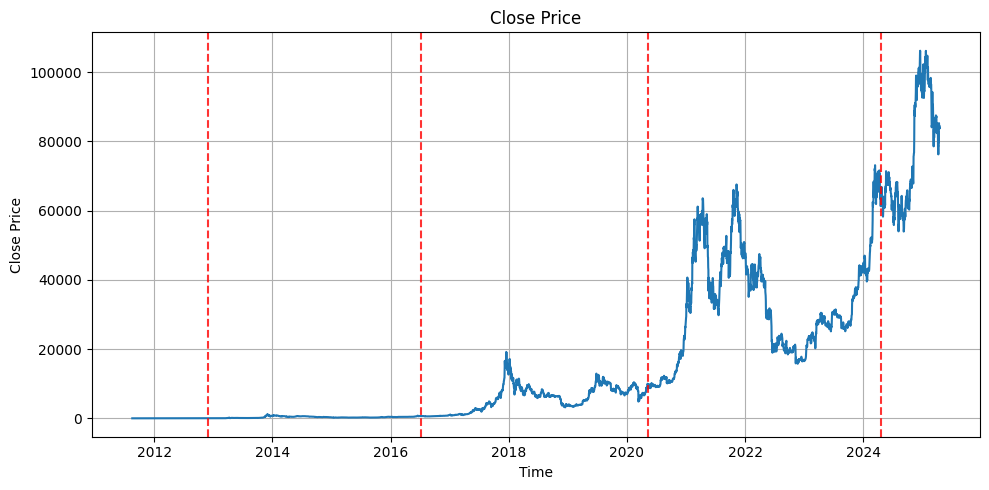

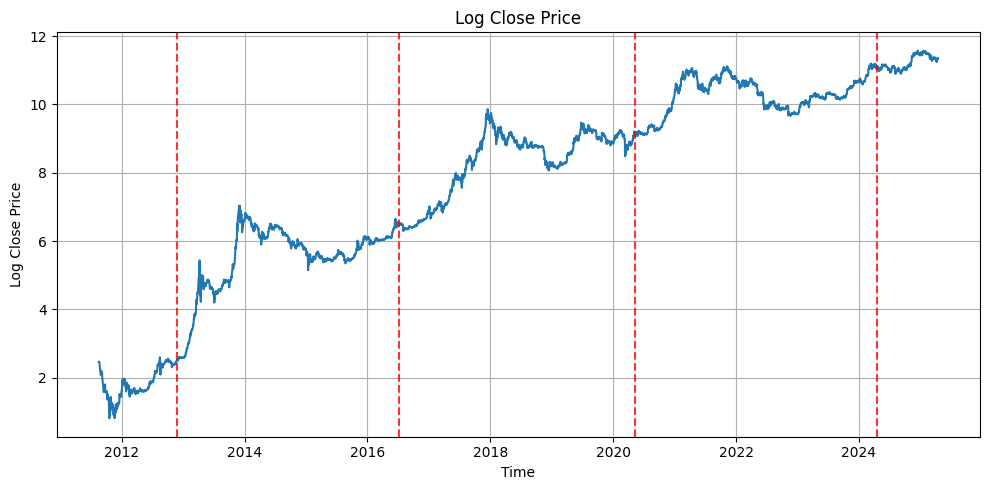

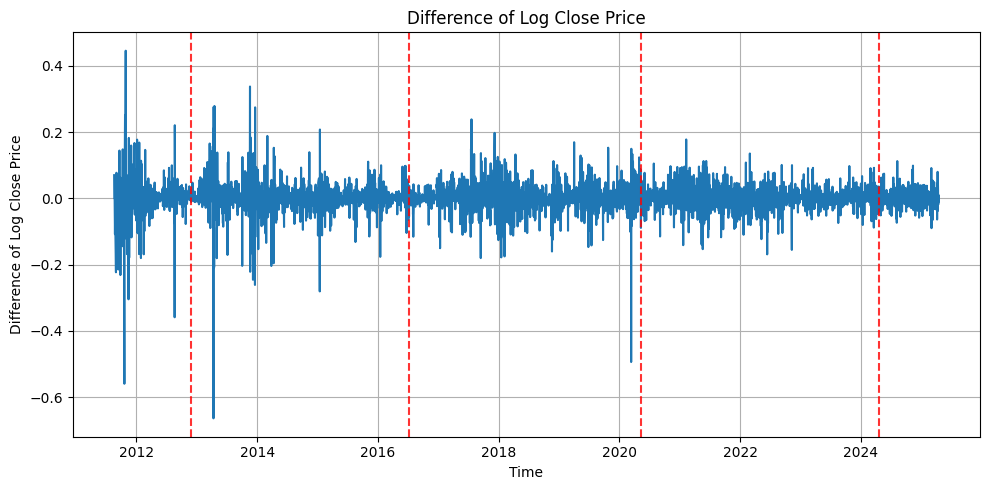

In [3]:
# Define halving dates
halving_dates = [
    pd.to_datetime("2012-11-28"),
    pd.to_datetime("2016-07-09"),
    pd.to_datetime("2020-05-11"),
    pd.to_datetime("2024-04-20")
]

plt.figure(figsize=(10, 5))
plt.plot(df['close'])
for date in halving_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.8, label='Halving' if date == halving_dates[0] else "")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df['ln_close'])
for date in halving_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.8, label='Halving' if date == halving_dates[0] else "")
plt.xlabel('Time')
plt.ylabel('Log Close Price')
plt.title('Log Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df['ln_diff'])
for date in halving_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.8, label='Halving' if date == halving_dates[0] else "")
plt.xlabel('Time')
plt.ylabel('Difference of Log Close Price')
plt.title('Difference of Log Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
def test_stationarity(series):
    print(f"=== Augmented Dickey-Fuller Test (ADF) ***{series.name}*** ===")
    adf_result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("=> Reject null hypothesis (non-stationary)?", "✅ Yes" if adf_result[1] < 0.05 else "❌ No")
    print()

    print(f"=== KPSS Test (Level Stationarity) ***{series.name}*** ===")
    kpss_result = kpss(series, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print("=> Reject null hypothesis (stationary)?", "✅ Yes" if kpss_result[1] < 0.05 else "❌ No")
    print("============================================================")

def auto_arma(y, max_p=5, max_q=5, criterion='aic', verbose=False):
    best_ic = np.inf
    best_order = None
    best_model = None
    results = []

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = sm.tsa.ARIMA(y, order=(p, 0, q)).fit()
                ic = model.aic if criterion == 'aic' else model.bic
                results.append({'p': p, 'q': q, criterion: ic})

                if verbose:
                    print(f"Trying ARMA({p},{q}): {criterion.upper()} = {ic:.2f}")

                if ic < best_ic:
                    best_ic = ic
                    best_order = (p, q)
                    best_model = model

            except Exception as e:
                if verbose:
                    print(f"Failed ARMA({p},{q}): {e}")
                continue

    results_df = pd.DataFrame(results).sort_values(by=criterion)
    return best_model, best_order, results_df



In [5]:
df

,open,high,low,close,rfr,ln_close,ln_diff,smoothed
time,,,,,,,,
2011-08-19,11.85,11.85,11.15,11.69,0.000000,2.458734,0.069971,NaN
2011-08-20,11.70,11.70,11.70,11.70,0.000000,2.459589,0.000855,NaN
2011-08-21,11.70,11.70,11.70,11.70,0.000000,2.459589,0.000000,NaN
2011-08-22,11.70,11.70,11.70,11.70,0.000100,2.459589,0.000000,NaN
2011-08-24,11.50,11.50,10.50,10.50,0.000200,2.351375,-0.108214,NaN
...,...,...,...,...,...,...,...,...
2025-04-12,83384.00,85892.00,82784.00,85274.00,0.042772,11.353625,0.022413,0.001682
2025-04-13,85277.00,86084.00,83031.00,83712.00,0.042772,11.335138,-0.018487,-0.000105
2025-04-14,83774.00,85787.00,83680.00,84583.00,0.042485,11.345489,0.010351,0.000093


In [6]:
print(test_stationarity(df['close']), test_stationarity(df['ln_diff']))

=== Augmented Dickey-Fuller Test (ADF) ***close*** ===
ADF Statistic: -0.4370
p-value: 0.9037
=> Reject null hypothesis (non-stationary)? ❌ No

=== KPSS Test (Level Stationarity) ***close*** ===
KPSS Statistic: 7.6131
p-value: 0.0100
=> Reject null hypothesis (stationary)? ✅ Yes
=== Augmented Dickey-Fuller Test (ADF) ***ln_diff*** ===
ADF Statistic: -13.6604
p-value: 0.0000
=> Reject null hypothesis (non-stationary)? ✅ Yes

=== KPSS Test (Level Stationarity) ***ln_diff*** ===
KPSS Statistic: 0.1785
p-value: 0.1000
=> Reject null hypothesis (stationary)? ❌ No
None None


/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_80931/1642220271.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_80931/1642220271.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [7]:
model = MarkovRegression(df["smoothed"].dropna(), k_regimes=3, trend='c', switching_variance=True)
result = model.fit()
print(result.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:               smoothed   No. Observations:                 4928
Model:               MarkovRegression   Log Likelihood               19480.653
Date:                Mon, 12 May 2025   AIC                         -38937.305
Time:                        15:09:10   BIC                         -38859.273
Sample:                             0   HQIC                        -38909.936
                               - 4928                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.000    -32.300      0.000      -0.005      -0.004
sigma2      7.527e-06   4.35e-07     17.320      0.0

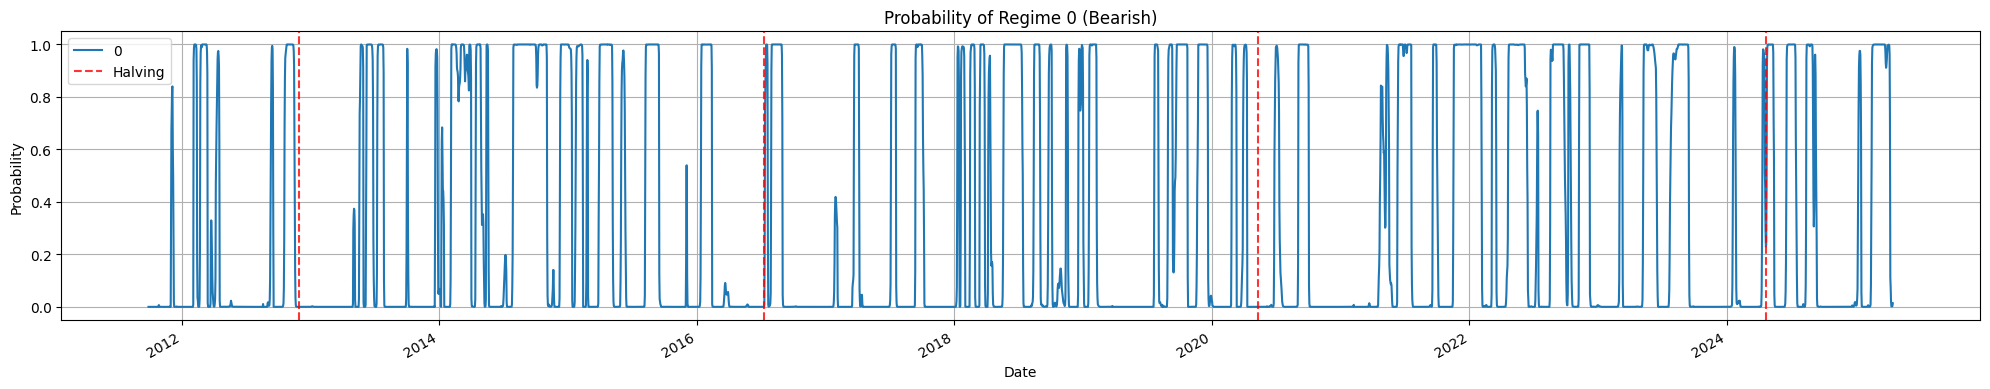

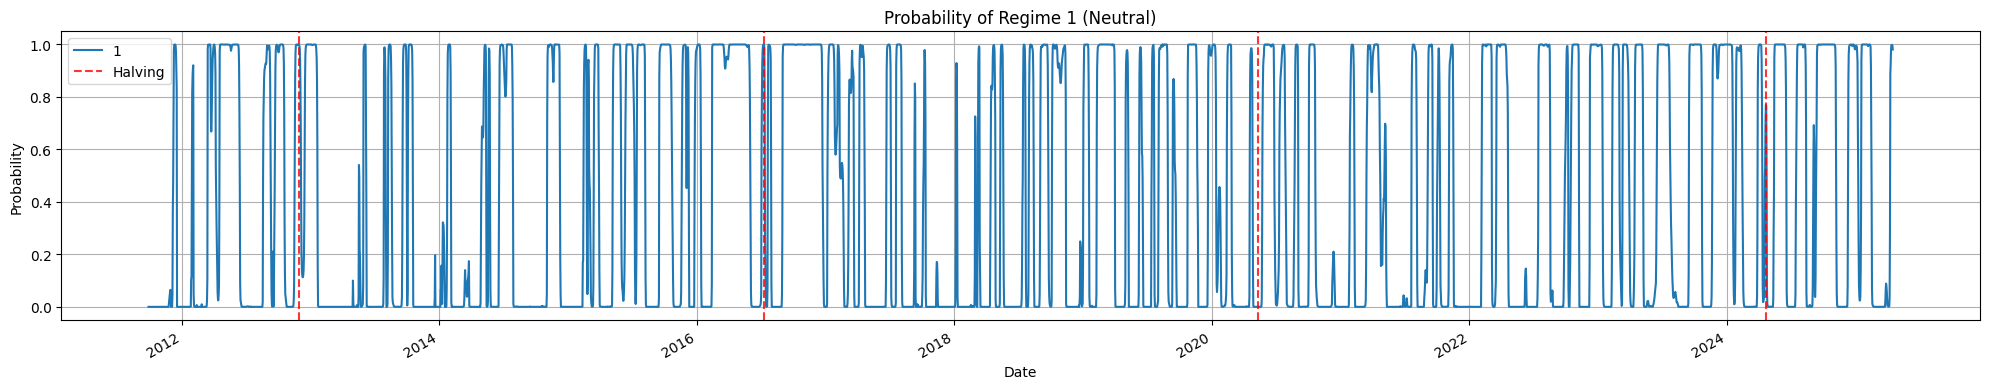

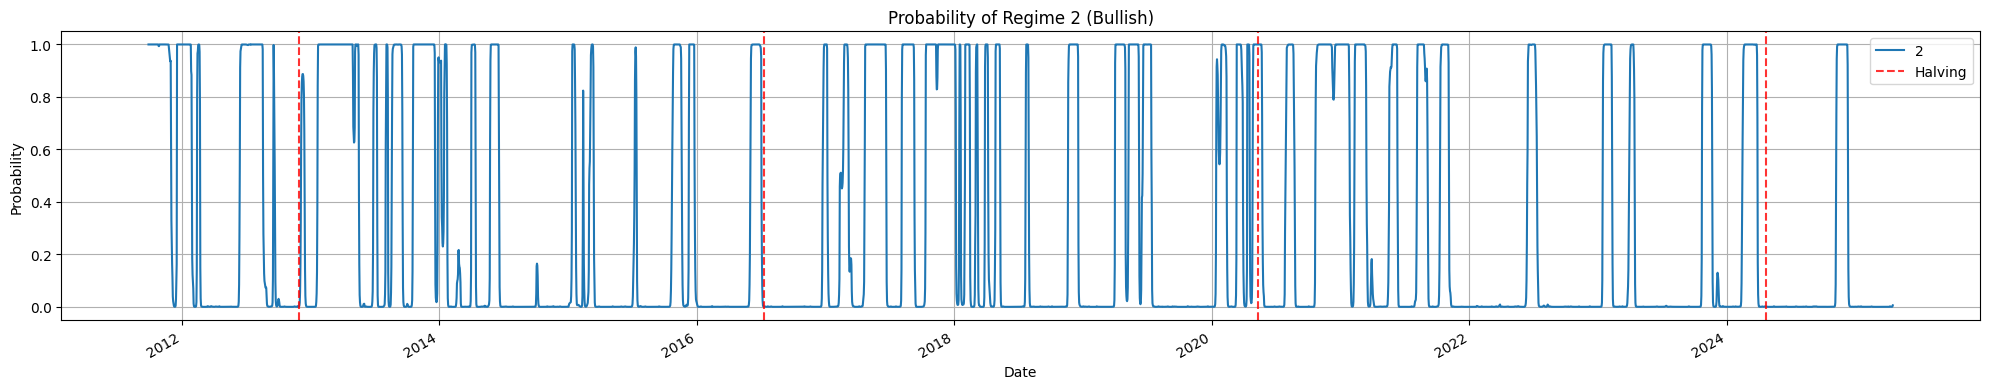

In [8]:
halving_dates = [
    pd.to_datetime("2012-11-28"),
    pd.to_datetime("2016-07-09"),
    pd.to_datetime("2020-05-11"),
    pd.to_datetime("2024-04-20")
]

result.smoothed_marginal_probabilities[0].plot(figsize=(20, 4), title="Probability of Regime 0 (Bearish)")
for date in halving_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.8, label='Halving' if date == halving_dates[0] else "")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Regime 1
result.smoothed_marginal_probabilities[1].plot(figsize=(20, 4), title="Probability of Regime 1 (Neutral)")
for date in halving_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.8, label='Halving' if date == halving_dates[0] else "")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

result.smoothed_marginal_probabilities[2].plot(figsize=(20, 4), title="Probability of Regime 2 (Bullish)")
for date in halving_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.8, label='Halving' if date == halving_dates[0] else "")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
regime_probs = result.smoothed_marginal_probabilities
most_probable_regime = regime_probs.idxmax(axis=1)

# Store contiguous stretches of each regime
regime_segments = []
prev_regime = most_probable_regime.iloc[0]
start_date = most_probable_regime.index[0]

for date, regime in most_probable_regime.items():
    if regime != prev_regime:
        end_date = date
        regime_segments.append({
            'regime': prev_regime,
            'start': start_date,
            'end': end_date,
            'duration_days': (end_date - start_date).days
        })
        start_date = date
        prev_regime = regime

# Catch final stretch
regime_segments.append({
    'regime': prev_regime,
    'start': start_date,
    'end': most_probable_regime.index[-1],
    'duration_days': (most_probable_regime.index[-1] - start_date).days
})

regime_df = pd.DataFrame(regime_segments)

min_duration = 50
merged_segments = []

for i, row in regime_df.iterrows():
    if row['duration_days'] >= min_duration or i == 0:
        merged_segments.append(dict(row))  # force dictionary format
    else:
        # Merge into previous segment
        prev = merged_segments.pop()
        merged = {
            'regime': prev['regime'],  # preserve previous regime
            'start': prev['start'],
            'end': row['end'],
            'duration_days': (row['end'] - prev['start']).days
        }
        merged_segments.append(merged)

# Rebuild cleaned regime series
cleaned_df = pd.DataFrame(merged_segments)

cleaned_regime = pd.Series(index=most_probable_regime.index, dtype='float')

for i, row in cleaned_df.iterrows():
    cleaned_regime.loc[row['start']:row['end']] = row['regime']

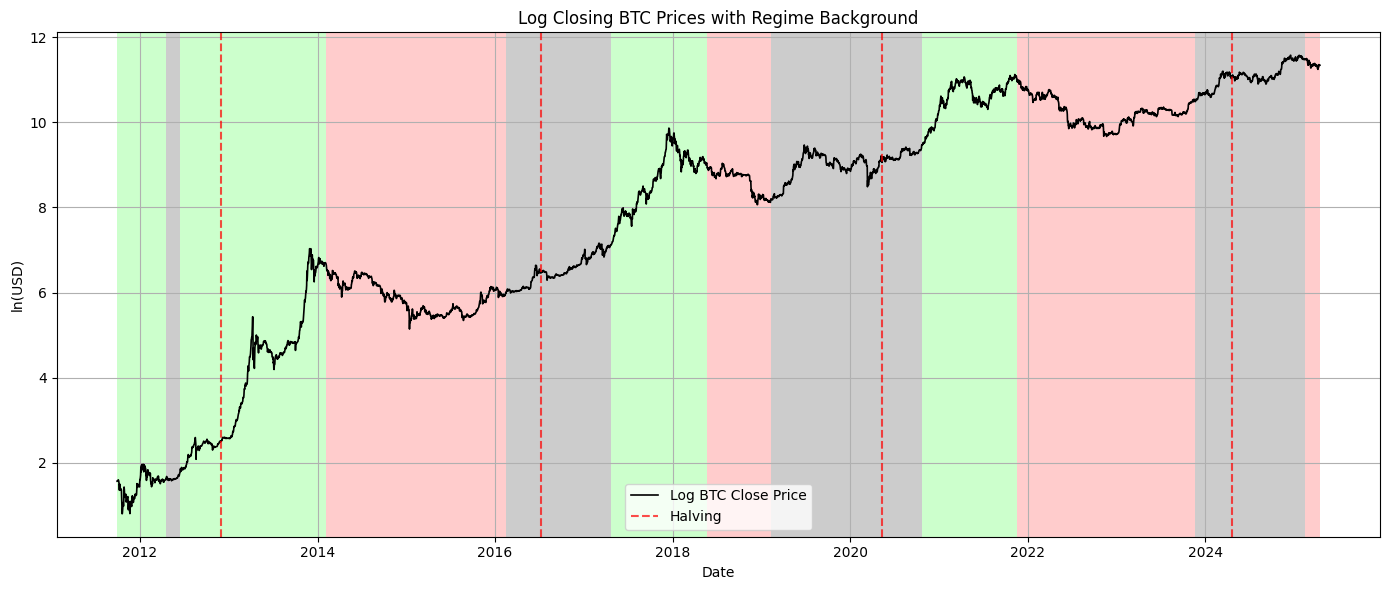

In [10]:
# Daily BTC prices aligned to the MSM output
most_probable_regime = cleaned_regime
btc_daily = df.loc[most_probable_regime.index, 'ln_close']

# Define regime colors
regime_colors = {
    0: (1.0, 0, 0, 0.2),  # transparent red
    1: (0.0, 0.0, 0.0, 0.2),  # neutral grey
    2: (0.0, 1.0, 0.0, 0.2),  # transparent green
}

# Plot BTC prices
plt.figure(figsize=(14, 6))
plt.plot(btc_daily, color='black', linewidth=1.2, label="Log BTC Close Price")

# Add background shading for regimes
current_regime = most_probable_regime.iloc[0]
start_date = most_probable_regime.index[0]

for date, regime in most_probable_regime.items():
    if regime != current_regime:
        plt.axvspan(start_date, date, color=regime_colors[current_regime], linewidth=0)
        start_date = date
        current_regime = regime
# Shade final segment
plt.axvspan(start_date, most_probable_regime.index[-1], color=regime_colors[current_regime], linewidth=0)

# Add halving lines
for i, date in enumerate(halving_dates):
    if btc_daily.index[0] <= date <= btc_daily.index[-1]:
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.7,
                    label='Halving' if i == 0 else None)

# Final touches
plt.title(f"Log Closing BTC Prices with Regime Background")
plt.xlabel("Date")
plt.ylabel("ln(USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


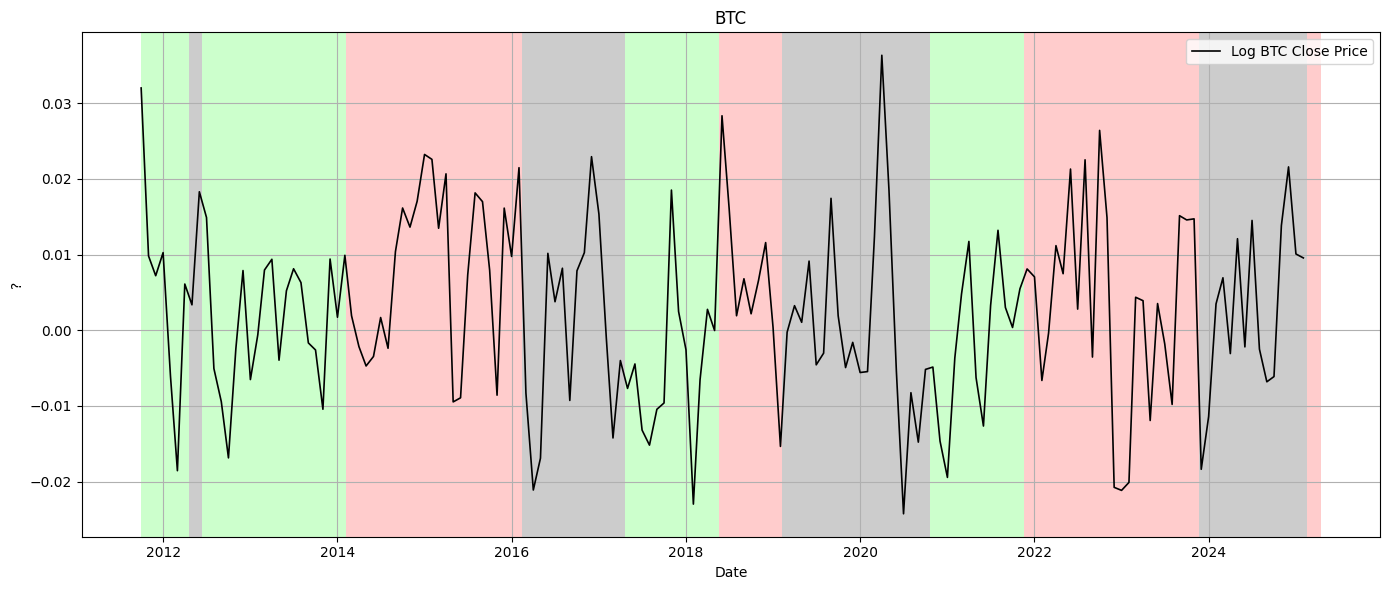

In [11]:
# Daily BTC prices aligned to the MSM output
most_probable_regime = cleaned_regime
btc_daily = regimes["usd_diff"].shift(1)

# Define regime colors
regime_colors = {
    0: (1.0, 0, 0, 0.2),  # transparent red
    1: (0.0, 0.0, 0.0, 0.2),  # neutral grey
    2: (0.0, 1.0, 0.0, 0.2),  # transparent green
}

# Plot BTC prices
plt.figure(figsize=(14, 6))
plt.plot(btc_daily, color='black', linewidth=1.2, label="Log BTC Close Price")

# Add background shading for regimes
current_regime = most_probable_regime.iloc[0]
start_date = most_probable_regime.index[0]

for date, regime in most_probable_regime.items():
    if regime != current_regime:
        plt.axvspan(start_date, date, color=regime_colors[current_regime], linewidth=0)
        start_date = date
        current_regime = regime
# Shade final segment
plt.axvspan(start_date, most_probable_regime.index[-1], color=regime_colors[current_regime], linewidth=0)

# Add halving lines
for i, date in enumerate(halving_dates):
    if btc_daily.index[0] <= date <= btc_daily.index[-1]:
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.7,
                    label='Halving' if i == 0 else None)

# Final touches
plt.title(f"BTC")
plt.xlabel("Date")
plt.ylabel("?")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


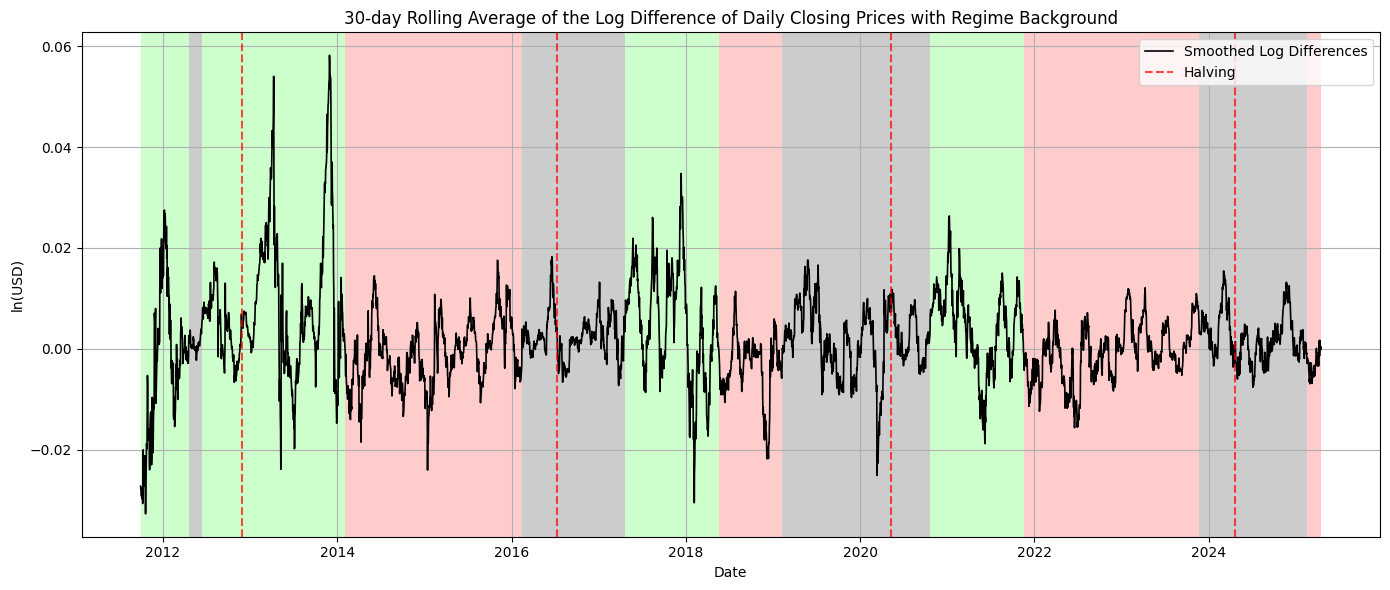

In [12]:
btc_daily = df.loc[most_probable_regime.index, 'smoothed']

# Define halving dates
halving_dates = [
    pd.to_datetime("2012-11-28"),
    pd.to_datetime("2016-07-09"),
    pd.to_datetime("2020-05-11"),
    pd.to_datetime("2024-04-20")
]

# Define regime colors
regime_colors = {
    0: (1, 0, 0, 0.2),  # transparent red
    1: (0.0, 0.0, 0.0, 0.2),  # neutral grey
    2: (0.0, 1.0, 0.0, 0.2),  # transparent green
}

# Plot BTC prices
plt.figure(figsize=(14, 6))
plt.plot(btc_daily, color='black', linewidth=1.2, label="Smoothed Log Differences")

# Add background shading for regimes
current_regime = most_probable_regime.iloc[0]
start_date = most_probable_regime.index[0]

for date, regime in most_probable_regime.items():
    if regime != current_regime:
        plt.axvspan(start_date, date, color=regime_colors[current_regime], linewidth=0)
        start_date = date
        current_regime = regime
# Shade final segment
plt.axvspan(start_date, most_probable_regime.index[-1], color=regime_colors[current_regime], linewidth=0)

# Add halving lines
for i, date in enumerate(halving_dates):
    if btc_daily.index[0] <= date <= btc_daily.index[-1]:
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.7,
                    label='Halving' if i == 0 else None)

# Final touches
plt.title(f"{n}-day Rolling Average of the Log Difference of Daily Closing Prices with Regime Background")
plt.xlabel("Date")
plt.ylabel("ln(USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Ensure cleaned_regime is sorted by date
cleaned_regime = cleaned_regime.sort_index()

# Initialize storage
regime_segments = []
current_regime = cleaned_regime.iloc[0]
start_date = cleaned_regime.index[0]

# Loop through to detect regime changes
for date, regime in cleaned_regime.items():
    if regime != current_regime:
        regime_segments.append({
            "regime": current_regime,
            "start_date": start_date,
            "end_date": date,
            "duration_days": (date - start_date).days
        })
        current_regime = regime
        start_date = date

# Handle last regime
regime_segments.append({
    "regime": current_regime,
    "start_date": start_date,
    "end_date": cleaned_regime.index[-1],
    "duration_days": (cleaned_regime.index[-1] - start_date).days
})

# Convert to DataFrame
import pandas as pd
regime_df = pd.DataFrame(regime_segments)

regime_df.to_csv("periods.csv", index=False)

In [14]:
# Your halving dates
halving_dates = [
    pd.to_datetime("2012-11-28"),
    pd.to_datetime("2016-07-09"),
    pd.to_datetime("2020-05-11"),
    pd.to_datetime("2024-04-20")
]

# Ensure regime_df has datetime index (if needed)
# regime_df already has 'start_date' and 'end_date' as datetime

# Prepare storage
estimation_windows = []

# Loop over each halving date
for hdate in halving_dates:
    # Find the regime segment that contains the halving date
    match = regime_df[(regime_df['start_date'] <= hdate) & (regime_df['end_date'] > hdate)]

    if match.empty:
        print(f"No regime found for halving date {hdate}")
        continue

    match_row = match.iloc[0]
    regime = match_row['regime']
    start_date = match_row['start_date']
    delta = (hdate - start_date).days

    print(f"Halving: {hdate.date()} | Regime: {regime} | Start: {start_date.date()} | Δt: {delta} days")

    estimation_window_end_date = hdate - pd.Timedelta(days=2)
    ln_diff_window = df.loc[start_date:estimation_window_end_date, 'ln_diff'].copy()

    window_df = ln_diff_window.to_frame().reset_index()
    window_df.columns = ['date', 'ln_diff']
    window_df['regime'] = regime
    window_df['end_date'] = estimation_window_end_date
    window_df['start_date'] = start_date
    window_df['days_to_halving'] = (window_df['date'] - start_date).dt.days

    estimation_windows.append(window_df)

    estimation_windows


Halving: 2012-11-28 | Regime: 2.0 | Start: 2012-06-14 | Δt: 167 days
Halving: 2016-07-09 | Regime: 1.0 | Start: 2016-02-14 | Δt: 146 days
Halving: 2020-05-11 | Regime: 1.0 | Start: 2019-02-09 | Δt: 457 days
Halving: 2024-04-20 | Regime: 1.0 | Start: 2023-11-21 | Δt: 151 days


In [15]:
df1, df2, df3, df4 = estimation_windows
df1

,date,ln_diff,regime,end_date,start_date,days_to_halving
0,2012-06-14,0.006803,2.0,2012-11-26,2012-06-14,0
1,2012-06-15,0.084466,2.0,2012-11-26,2012-06-14,1
2,2012-06-16,-0.001559,2.0,2012-11-26,2012-06-14,2
3,2012-06-17,-0.034924,2.0,2012-11-26,2012-06-14,3
4,2012-06-18,-0.021225,2.0,2012-11-26,2012-06-14,4
...,...,...,...,...,...,...
161,2012-11-22,0.017835,2.0,2012-11-26,2012-06-14,161
162,2012-11-23,0.023296,2.0,2012-11-26,2012-06-14,162
163,2012-11-24,0.007374,2.0,2012-11-26,2012-06-14,163
164,2012-11-25,0.004886,2.0,2012-11-26,2012-06-14,164


In [16]:
mean1 = df1['ln_diff'].mean()
mean2 = df2['ln_diff'].mean()
mean3 = df3['ln_diff'].mean()
mean4 = df4['ln_diff'].mean()
event_window = 5

In [17]:
merged = df.join(crypto, how='inner')
merged["y"] = merged["ln_diff"] - merged["rfr"]
merged["x"] = merged["cap_diff"] - merged["rfr"]

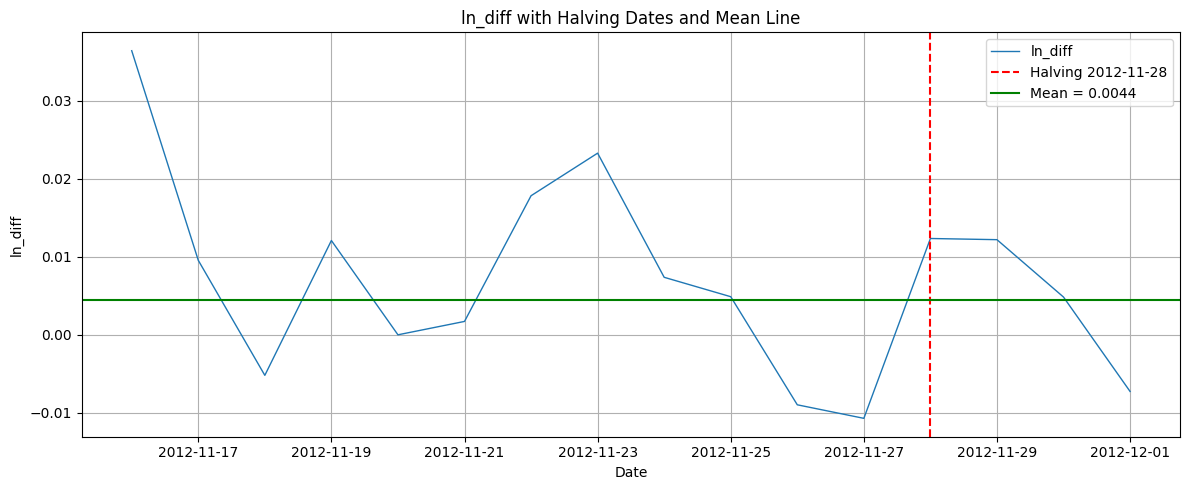

In [18]:
start_date = df1["end_date"][0] - pd.Timedelta(days=10)
end_date = df1["end_date"][0] + pd.Timedelta(days=event_window)
subset = df.loc[start_date:end_date, 'ln_diff']

mean = mean1

# Plot
plt.figure(figsize=(12, 5))
plt.plot(subset.index, subset, label='ln_diff', linewidth=1)

# Add halving date vertical lines
for hdate in halving_dates:
    if start_date <= hdate <= end_date:
        plt.axvline(hdate, color='red', linestyle='--', label=f'Halving {hdate.date()}')

# Add horizontal mean line
plt.axhline(mean, color='green', linestyle='-', label=f'Mean = {mean:.4f}')

# Formatting
plt.title('ln_diff with Halving Dates and Mean Line')
plt.xlabel('Date')
plt.ylabel('ln_diff')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_80931/1929835731.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_fitted2["CCAPM_returns"] = merged_fitted2["rfr"] + beta2 * merged_fitted2["x"]


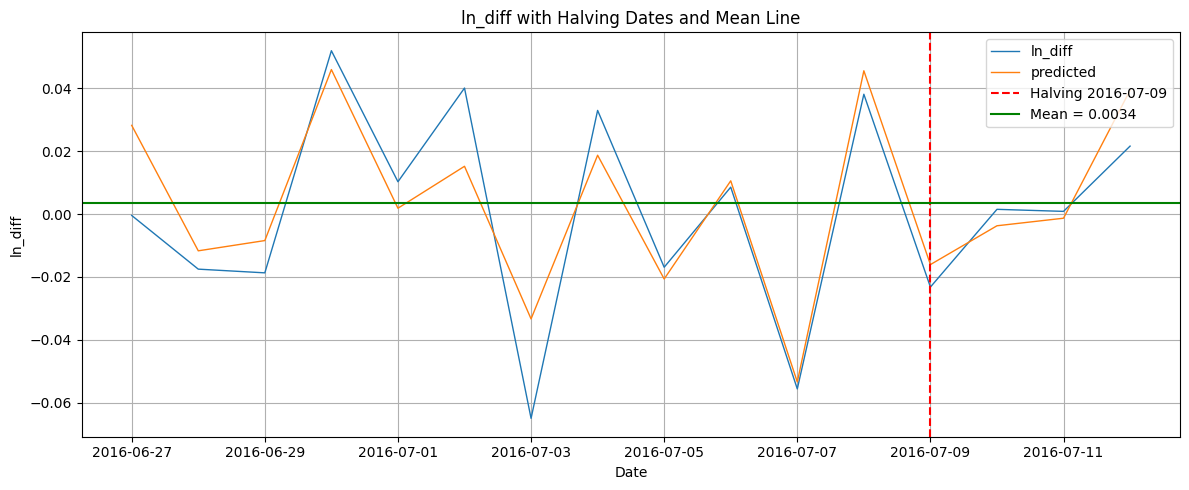

In [19]:
start_date = df2["end_date"][0] - pd.Timedelta(days=10)
end_date = df2["end_date"][0] + pd.Timedelta(days=event_window)
subset = df.loc[start_date:end_date, 'ln_diff']
merged2x = merged.loc[df2["start_date"][0]:df2["end_date"][0], "x"]
merged2y = merged.loc[df2["start_date"][0]:df2["end_date"][0], "y"]

mean = mean2

CCAPM2 = sm.OLS(merged2y, merged2x).fit()
beta2 = CCAPM2.params["x"]
merged_fitted2 = merged.loc[start_date:end_date]
merged_fitted2["CCAPM_returns"] = merged_fitted2["rfr"] + beta2 * merged_fitted2["x"]
predicted = merged_fitted2["CCAPM_returns"]


# Plot
plt.figure(figsize=(12, 5))
plt.plot(subset.index, subset, label='ln_diff', linewidth=1)
plt.plot(subset.index, predicted, label='predicted', linewidth=1)

# Add halving date vertical lines
for hdate in halving_dates:
    if start_date <= hdate <= end_date:
        plt.axvline(hdate, color='red', linestyle='--', label=f'Halving {hdate.date()}')

# Add horizontal mean line
plt.axhline(mean, color='green', linestyle='-', label=f'Mean = {mean:.4f}')

# Formatting
plt.title('ln_diff with Halving Dates and Mean Line')
plt.xlabel('Date')
plt.ylabel('ln_diff')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_80931/3803676464.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_fitted3["CCAPM_returns"] = merged_fitted3["rfr"] + beta3 * merged_fitted3["x"]


ValueError: x and y must have same first dimension, but have shapes (16,) and (15,)

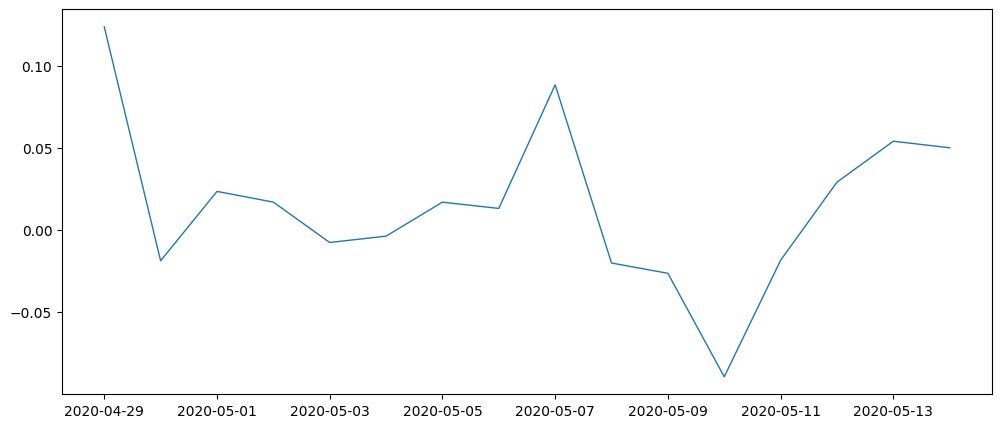

In [20]:
start_date = df3["end_date"][0] - pd.Timedelta(days=10)
end_date = df3["end_date"][0] + pd.Timedelta(days=event_window)
subset = df.loc[start_date:end_date, 'ln_diff']
merged3x = merged.loc[df3["start_date"][0]:df3["end_date"][0], "x"]
merged3y = merged.loc[df3["start_date"][0]:df3["end_date"][0], "y"]

mean = mean3

CCAPM3 = sm.OLS(merged3y, merged3x).fit()
beta3 = CCAPM3.params["x"]
merged_fitted3 = merged.loc[start_date:end_date]
merged_fitted3["CCAPM_returns"] = merged_fitted3["rfr"] + beta3 * merged_fitted3["x"]
predicted = merged_fitted3["CCAPM_returns"]


# Plot
plt.figure(figsize=(12, 5))
plt.plot(subset.index, subset, label='ln_diff', linewidth=1)
plt.plot(subset.index, predicted, label='predicted', linewidth=1)

# Add halving date vertical lines
for hdate in halving_dates:
    if start_date <= hdate <= end_date:
        plt.axvline(hdate, color='red', linestyle='--', label=f'Halving {hdate.date()}')

# Add horizontal mean line
plt.axhline(mean, color='green', linestyle='-', label=f'Mean = {mean:.4f}')

# Formatting
plt.title('ln_diff with Halving Dates and Mean Line')
plt.xlabel('Date')
plt.ylabel('ln_diff')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

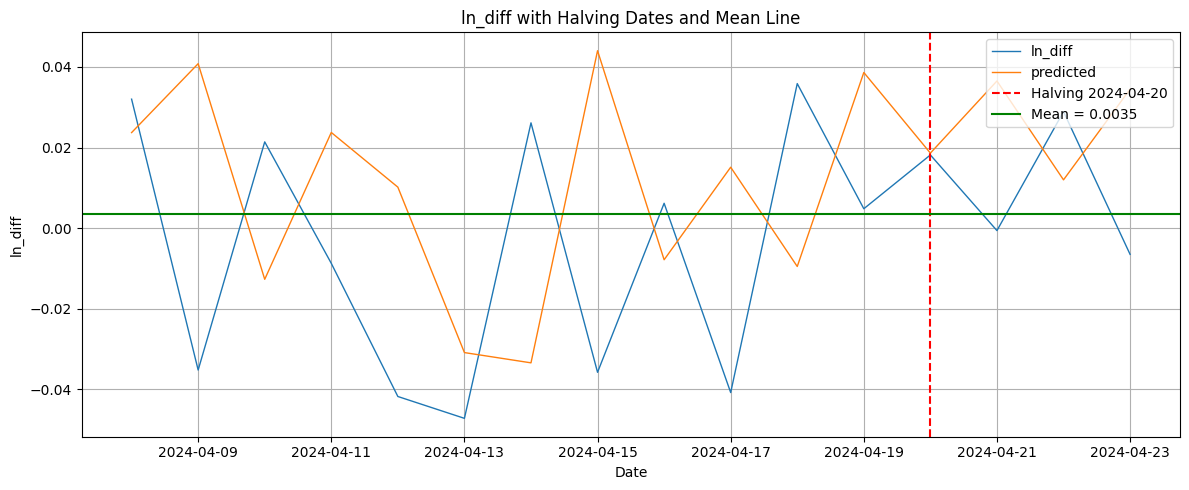

In [ ]:
start_date = df4["end_date"][0] - pd.Timedelta(days=10)
end_date = df4["end_date"][0] + pd.Timedelta(days=event_window)
subset = df.loc[start_date:end_date, 'ln_diff']
merged4x = merged.loc[df4["start_date"][0]:df4["end_date"][0], "x"]
merged4y = merged.loc[df4["start_date"][0]:df4["end_date"][0], "y"]

mean = mean4

CCAPM4 = sm.OLS(merged4y, merged4x).fit()
beta4 = CCAPM4.params["x"]
merged_fitted4 = merged.loc[start_date:end_date]
merged_fitted4["CCAPM_returns"] = merged_fitted4["rfr"] + beta4 * merged_fitted4["x"]
predicted = merged_fitted4["CCAPM_returns"]


# Plot
plt.figure(figsize=(12, 5))
plt.plot(subset.index, subset, label='ln_diff', linewidth=1)
plt.plot(subset.index, predicted, label='predicted', linewidth=1)

# Add halving date vertical lines
for hdate in halving_dates:
    if start_date <= hdate <= end_date:
        plt.axvline(hdate, color='red', linestyle='--', label=f'Halving {hdate.date()}')

# Add horizontal mean line
plt.axhline(mean, color='green', linestyle='-', label=f'Mean = {mean:.4f}')

# Formatting
plt.title('ln_diff with Halving Dates and Mean Line')
plt.xlabel('Date')
plt.ylabel('ln_diff')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()